# Backtrack Testbed Notebook

Short notebook to test Bryans functions.

In [25]:
# Standard library
import sys

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import metpy 

We want MetPy ver 1.6.1

In [26]:
# !pip install metpy --upgrade

In [27]:
print(f" Harnessing the power of MetPy version {metpy.__version__} ️")

 Harnessing the power of MetPy version 1.6.1 ️


In [28]:
sys.path.insert(1, '../sealsml')

In [29]:
from geometry import GeoCalculator, polar_to_cartesian

# lets try to find Ch4 max, first lets make an array of random ch4 data

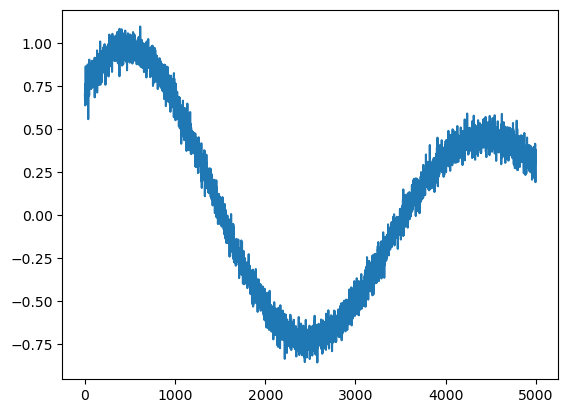

In [30]:
# Define number of data points
N = 5000

# Generate random frequencies and amplitudes for sin and cos
freq_sin = np.random.uniform(0.1, 0.5)
amp_sin = np.random.uniform(0.5, 1.5)
freq_cos = np.random.uniform(0.2, 0.8)
amp_cos = np.random.uniform(0.5, 1.5)

# Generate time series data as a 1D array
t = np.linspace(0, 20, N)
data = amp_sin * np.sin(freq_sin * t) + amp_cos * np.cos(freq_cos * t) + np.random.randn(N) * 0.05

plt.plot(data)


In [31]:
from backtrack import findmaxCH4

In [32]:
%%time
max_c_noloop, time_max_c_noloop, ijk_max_noloop = findmaxCH4(data, t)

CPU times: user 27 µs, sys: 5 µs, total: 32 µs
Wall time: 32.9 µs


#### findmaxCH4 has been tested by Bryan, seems to work as intended

# Backtrack Function Testing

In [33]:
from backtrack import backtrack

## These variables are all made up. Just looking to see what it requires and see if it runs. 

In [34]:
sensor_x = 1
sensor_y = 2

pathmax = 3.2
dt = 1

ijk_start = 2

u_sonic = u_data
v_sonic = v_data

In [35]:
np.size(ijk_start)

1

In [36]:
%%time
backtrack(ijk_start, u_sonic, v_sonic, dt, sensor_x, sensor_y, 5)

CPU times: user 45 µs, sys: 1e+03 ns, total: 46 µs
Wall time: 49.1 µs


(0.02970741453384529, -5.129250498882499)

### Pathmax Function

In [37]:
from backtrack import pathmax

In [44]:
factor_x = 0.5
x_width = 11
factor_y = 0.25
y_width = 30


In [45]:
paths = pathmax( x_width, y_width, factor_x, factor_y)
paths

5.5

### Data ingester for B Travis

In [46]:
data = '../test_data/training_data_SBL2m_Ug2p5_src1-8kg_b.5.nc'

In [47]:
ds = xr.load_dataset(data)

In [48]:
x = ds.encoder_input.isel(mask=0).values

Sanity check for dx, dy, dz

In [66]:
random_array = np.random.rand(3, 1)
random_array

array([[0.06286837],
       [0.00259953],
       [0.88510047]])

I need to clean this up, and add ch4 to the output. But this is what I have so far. 

In [68]:
def create_input_data_for_bryan(x, num_met_sensors =1, num_sensors = 3):
    '''
    This function uses numpy arrays as input
    The variable should have a length of 8: ['ref_distance', 'ref_azi_sin', 'ref_azi_cos', 'ref_elv', 'u', 'v', 'w', 'q_CH4']
    '''
    print('Shape of input x', x.shape)

    n_timesteps = x.shape[2]

    factor_x = 0.4
    x_width = 40
    factor_y = 0.4
    y_width = 40

    dt = 1

    pathmax_value = pathmax( x_width, y_width, factor_x, factor_y)

    complete_array = []

    for i in range(x.shape[0]): # this loop might be unessary
        # print('sample numnber', i)

        # append to some lists
        backtrack_u_ = []
        backtrack_v_ = []
        max_idx_ = []
        ch4_matrix = []

        ## U & V time series extracted from met sensor
        u = x[i][[0], :, 4]
        v = x[i][[0], :, 5]
        
        # pulling met sensor location
        # right now this is not an issue because the met sensor is 0,0, will need to think about when we add a second one
        met_dist = x[i][[0], :, 0].T[0]
        met_azi_sin  = x[i][[0], :, 1].T[0]
        met_azi_cos  = x[i][[0], :, 2].T[0]
        x_met, y_met = polar_to_cartesian(met_dist, met_azi_sin, met_azi_cos)

        # pulling the information from the ch4 sensors, distance, azi_sin and azi_cos and ch4
        ref_dist = x[i][[1, 2, 3], :, 0].T[0]
        azi_sin  = x[i][[1, 2, 3], :, 1].T[0]
        azi_cos  = x[i][[1, 2, 3], :, 2].T[0]
        ch4_data_ts = x[i][[1, 2, 3], :, 7]

        x_, y_ = polar_to_cartesian(ref_dist, azi_sin, azi_cos)
        ref_elevation  = x[i][[1, 2, 3], :, 3].T[0]
        stacked_data = np.column_stack((x_, y_, ref_elevation))
        # This variable is 3 by 9 
        repeated_pos = np.repeat(stacked_data, num_sensors).reshape(9,num_sensors).T

        ## emissions data
        for q in range(num_sensors):
            # print('sensor number', q+1)
            
            ch4_data = x[i][[1, 2, 3], :, 7][q]
            #print(ch4_data.shape)
            # findmaxch4
            max_c, time_max_c, max_idx = findmaxCH4(ch4_data, np.arange(n_timesteps)) 
            #print('max_c, max_idx, time_max_c')
            #print(max_c, max_idx, time_max_c)
            backtrack_u, backtrack_v = backtrack(ijk_start=time_max_c, u_sonic=u.ravel(), v_sonic=v.ravel(), dt=dt, sensor_x=x_met[0], sensor_y=y_met[0], pathmax=pathmax_value)

            # append
            backtrack_u_.append(backtrack_u)
            backtrack_v_.append(backtrack_v)
            max_idx_.append(max_idx)
        
        ch4_matrix.append(ch4_data_ts[:, max_idx_].T)
        ch4_matrix_array = np.array(ch4_matrix).squeeze()
        backtrack_u_array = np.array(backtrack_u_).reshape(3, 1)
        backtrack_v_array = np.array(backtrack_v_).reshape(3, 1)
        merged_array = np.concatenate((backtrack_u_array, backtrack_v_array, repeated_pos, ch4_matrix_array), axis=1)
        complete_array.append(merged_array)
    # Goal to export:
    # backtrack_u, backtrack_v, x, y, z, x1, y1, z1, x2, y2, z2, ch4, ch4-1, ch4-2
    # that three times
    print('shape of export array:', np.array(complete_array).reshape(600 * 3, 14).shape)
    return np.array(complete_array).reshape(600 * 3, 14)

## Export

In [51]:
tar_ = ds.target.values

In [52]:
y = ds.decoder_input.isel(mask=0).values
y_ = y.squeeze()

In [53]:
def bryan_output(y, target, number_of_sensors = 3):
    #
    export_array = []
    num_sensors_int = np.int64(number_of_sensors)
    print(type(num_sensors_int))
    winners = np.argmax(target.squeeze(), axis=1)
    num_samples = np.int64(winners.shape)
    
    print('number of samples', num_samples)
    # figuring out which one is the leaky one
    for q in np.arange(len(winners)):
        leak_ = winners[q]
        # print('leak:', leak_)
        # pulling that data out 
        dist_sin_cos_elevation = y[q][leak_][:, :4].ravel()
    
        x_, y_ = polar_to_cartesian(dist_sin_cos_elevation[0], 
                                    dist_sin_cos_elevation[1], 
                                    dist_sin_cos_elevation[2])

        z_ = dist_sin_cos_elevation[3]
        row_array = np.asarray([x_, y_, z_])
        repeated_array = np.tile(row_array, (number_of_sensors, 1))
        export_array.append(repeated_array)
    reshape_size = num_sensors_int*num_samples
    
    return np.array(export_array).reshape(np.int64(reshape_size[0]), num_sensors_int)

In [54]:
yo = bryan_output(y, tar_)

<class 'numpy.int64'>
number of samples [600]


In [55]:
ds

<xarray.Dataset>
Dimensions:         (variable: 8, sample: 600, sensor: 10, time: 100, mask: 2,
                     pot_leak: 20, target_time: 1, sensor_loc: 3)
Coordinates:
  * variable        (variable) object 'ref_distance' 'ref_azi_sin' ... 'q_CH4'
  * sensor_loc      (sensor_loc) object 'xPos' 'yPos' 'zPos'
Dimensions without coordinates: sample, sensor, time, mask, pot_leak,
                                target_time
Data variables:
    encoder_input   (sample, sensor, time, variable, mask) float64 0.0 ... -1.0
    decoder_input   (sample, pot_leak, target_time, variable, mask) float64 3...
    target          (sample, pot_leak, target_time) float64 0.0 0.0 ... 0.0 0.0
    sensor_meta     (sample, sensor, sensor_loc) float64 207.0 2.409e+03 ... 0.0
    leak_meta       (sample, pot_leak, sensor_loc) float64 177.0 ... 0.0
    met_sensor_loc  (sample, sensor_loc) float64 207.0 2.409e+03 ... 3.001

In [56]:
yo.shape

(1800, 3)

## Argmin of Distance

We need a workflow to find the minimum distance, mark that as 1, and then pad it to 20 leak locations

In [57]:
random_arr = np.random.uniform(-10, 10, size=(20, 3))
random_arr

array([[ 4.97333141, -4.49052243,  9.85594671],
       [-9.92703317,  5.08951787,  6.05352738],
       [-7.01324487, -3.12827604,  4.06504405],
       [ 5.42934938, -6.38696281,  4.50468313],
       [ 6.63920188,  8.49129229, -6.16980376],
       [-5.77573535,  8.41436996,  5.26831482],
       [ 0.93593938, -1.15141526,  7.79920895],
       [ 4.80934427,  4.79016068, -0.52872141],
       [-2.64935808, -5.8556691 ,  6.35507989],
       [ 2.23852415,  2.73393596, -7.38040851],
       [ 5.88336817,  1.34148091,  1.99061042],
       [ 3.01664347, -5.37712541, -5.51926482],
       [ 8.66956417, -4.89483631,  7.99280093],
       [ 2.9284691 ,  2.40461047, -5.53091897],
       [ 3.90661541,  8.90892392,  4.87094777],
       [ 0.63716596,  5.47194712, -4.21256816],
       [-2.20089705,  3.0491147 ,  1.75499687],
       [ 4.94715085,  5.66847566, -1.13545239],
       [ 8.09768551,  4.3823828 ,  4.6291588 ],
       [ 2.32030441, -0.80482376, -2.09084247]])

In [58]:
ref_arr = np.random.uniform(-10, 10, size=(1, 3))
ref_arr

array([[-2.69596905, -5.37466515,  7.06422666]])

In [59]:
geo = GeoCalculator(ref_array=ref_arr, target_array=random_arr)
three_dist = geo.distance_between_points_3d()

In [60]:
arg_min = np.argmin(three_dist)
arg_min

8

In [61]:
zeros_array = np.zeros((20, 1))
zeros_array[arg_min] = 1
zeros_array

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [62]:
zeros_array.shape

(20, 1)

Padded to 20

#### Let's try on 'real' data

In [63]:
ds

<xarray.Dataset>
Dimensions:         (variable: 8, sample: 600, sensor: 10, time: 100, mask: 2,
                     pot_leak: 20, target_time: 1, sensor_loc: 3)
Coordinates:
  * variable        (variable) object 'ref_distance' 'ref_azi_sin' ... 'q_CH4'
  * sensor_loc      (sensor_loc) object 'xPos' 'yPos' 'zPos'
Dimensions without coordinates: sample, sensor, time, mask, pot_leak,
                                target_time
Data variables:
    encoder_input   (sample, sensor, time, variable, mask) float64 0.0 ... -1.0
    decoder_input   (sample, pot_leak, target_time, variable, mask) float64 3...
    target          (sample, pot_leak, target_time) float64 0.0 0.0 ... 0.0 0.0
    sensor_meta     (sample, sensor, sensor_loc) float64 207.0 2.409e+03 ... 0.0
    leak_meta       (sample, pot_leak, sensor_loc) float64 177.0 ... 0.0
    met_sensor_loc  (sample, sensor_loc) float64 207.0 2.409e+03 ... 3.001

This is in progress

In [64]:
def bryan_output_export(y, target, number_of_sensors = 3):
    #
    export_array = []
    num_sensors_int = np.int64(number_of_sensors)
    print(type(num_sensors_int))
    winners = np.argmax(target.squeeze(), axis=1)
    num_samples = np.int64(winners.shape)
    
    print('number of samples', num_samples)
    # figuring out which one is the leaky one
    for q in np.arange(len(winners)):
        leak_ = winners[q]
        # print('leak:', leak_)
        # pulling that data out 
        dist_sin_cos_elevation = y[q][leak_][:, :4].ravel()
    
        x_, y_ = polar_to_cartesian(dist_sin_cos_elevation[0], 
                                    dist_sin_cos_elevation[1], 
                                    dist_sin_cos_elevation[2])

        z_ = dist_sin_cos_elevation[3]
        row_array = np.asarray([x_, y_, z_])
        repeated_array = np.tile(row_array, (number_of_sensors, 1))
        export_array.append(repeated_array)
    reshape_size = num_sensors_int*num_samples
    
    return np.array(export_array).reshape(np.int64(reshape_size[0]), num_sensors_int)